In [ ]:
!pip install beir
!pip install -U sentence-transformers
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/11

In [ ]:
from typing import Dict, List, Tuple
from __future__ import annotations

from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from beir.retrieval import models

import pathlib, os, string
from tqdm.notebook import tqdm

import spacy

import time
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import multiprocessing as mp
import string
import math
import collections

from sentence_transformers import SentenceTransformer

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Application running on {device}")

/usr/local/lib/python3.10/dist-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Application running on cuda


# Available Datasets

| Dataset   | Website| BEIR-Name | Domain     | Relevancy| Queries  | Documents | Avg. Docs/Q | Download | 
| -------- | -----| ---------| ----------- | ---------| ---------| --------- | ------| ------------| 
| MSMARCO    | [``Homepage``](https://microsoft.github.io/msmarco/)| ``msmarco`` | Misc.       |  Binary  |  6,980   |  8.84M     |    1.1 | Yes |  
| TREC-COVID |  [``Homepage``](https://ir.nist.gov/covidSubmit/index.html)| ``trec-covid``| Bio-Medical |  3-level|50|  171K| 493.5 | Yes | 
| NFCorpus   | [``Homepage``](https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/) | ``nfcorpus``  | Bio-Medical |  3-level |  323     |  3.6K     |  38.2 | Yes |
| BioASQ     | [``Homepage``](http://bioasq.org) | ``bioasq``| Bio-Medical |  Binary  |   500    |  14.91M    |  8.05 | No | 
| NQ         | [``Homepage``](https://ai.google.com/research/NaturalQuestions) | ``nq``| Wikipedia   |  Binary  |  3,452   |  2.68M  |  1.2 | Yes | 
| HotpotQA   | [``Homepage``](https://hotpotqa.github.io) | ``hotpotqa``| Wikipedia   |  Binary  |  7,405   |  5.23M  |  2.0 | Yes |
| FiQA-2018  | [``Homepage``](https://sites.google.com/view/fiqa/) | ``fiqa``    | Finance     |  Binary  |  648     |  57K    |  2.6 | Yes | 
| Signal-1M (RT) | [``Homepage``](https://research.signal-ai.com/datasets/signal1m-tweetir.html)| ``signal1m`` | Twitter     |  3-level  |   97   |  2.86M  |  19.6 | No |
| TREC-NEWS  | [``Homepage``](https://trec.nist.gov/data/news2019.html) | ``trec-news``    | News     |  5-level  |   57    |  595K    |  19.6 | No |
| ArguAna    | [``Homepage``](http://argumentation.bplaced.net/arguana/data) | ``arguana`` | Misc.       |  Binary  |  1,406     |  8.67K    |  1.0 | Yes |
| Touche-2020| [``Homepage``](https://webis.de/events/touche-20/shared-task-1.html) | ``webis-touche2020``| Misc.       |  6-level  |  49     |  382K    |  49.2 |  Yes |
| CQADupstack| [``Homepage``](http://nlp.cis.unimelb.edu.au/resources/cqadupstack/) | ``cqadupstack``| StackEx.      |  Binary  |  13,145 |  457K  |  1.4 |  Yes |
| Quora| [``Homepage``](https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs) | ``quora``| Quora  | Binary  |  10,000     |  523K    |  1.6 |  Yes | 
| DBPedia | [``Homepage``](https://github.com/iai-group/DBpedia-Entity/) | ``dbpedia-entity``| Wikipedia |  3-level  |  400    |  4.63M    |  38.2 |  Yes | 
| SCIDOCS| [``Homepage``](https://allenai.org/data/scidocs) | ``scidocs``| Scientific |  Binary  |  1,000     |  25K    |  4.9 |  Yes | 
| FEVER| [``Homepage``](http://fever.ai) | ``fever``| Wikipedia     |  Binary  |  6,666     |  5.42M    |  1.2|  Yes | 
| Climate-FEVER| [``Homepage``](http://climatefever.ai) | ``climate-fever``| Wikipedia |  Binary  |  1,535     |  5.42M |  3.0 |  Yes |
| SciFact| [``Homepage``](https://github.com/allenai/scifact) | ``scifact``| Scientific |  Binary  |  300     |  5K    |  1.1 |  Yes |


# Data Loading

In [ ]:
# Importing drive to download or update datasets
from google.colab import drive
drive.mount('/content/drive/')
preprocessed_drive_path = '/content/drive/MyDrive/preprocessed_datasets'

Mounted at /content/drive/


In [ ]:
def download_dataset(dataset: str) -> Tuple[Dict[str, Dict[str, str]], Dict[str, Dict[str, str]]]:
  '''
  PURPOSE: download the dataset
  ARGUMENTS:
    - dataset (str): string describing the beir dataset
  RETURN:
    - corpus, queries (Tuple[Dict[str, Dict[str, str]], Dict[str, Dict[str, str]]]): documents, queries of the respective dataset
  '''
  data_path = f'datasets/{dataset}'
  if not os.path.isdir(data_path):
    url = f'https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip'
    out_dir = os.path.join(os.getcwd(), 'datasets')
    data_path = util.download_and_unzip(url, out_dir)
    print(f'Dataset downloaded here: {data_path}')
  corpus, queries, _ = GenericDataLoader(data_path).load(split="test")
  return corpus, queries


datasets = ['scifact', 'nfcorpus'] # Choosen datasets 

datasets_data = {}
number_k_prime_values = 20

for dataset in datasets:
  corpus, queries = download_dataset(dataset)
  datasets_data[dataset] = {
      'corpus': corpus,
      'queries': queries,
  }


k_prime_values = [i for i in range(1, 2500, 2500 // number_k_prime_values)]
k_ground_truth = [1, 10, 100, 500, 800, 1000]

/content/datasets/scifact.zip:   0%|          | 0.00/2.69M [00:00<?, ?iB/s]

Dataset downloaded here: /content/datasets/scifact


  0%|          | 0/5183 [00:00<?, ?it/s]

/content/datasets/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

Dataset downloaded here: /content/datasets/nfcorpus


  0%|          | 0/3633 [00:00<?, ?it/s]

# Document Pre-Processing

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
clean_tokens = lambda tokens : ' '.join([token.lemma_.lower() for token in tokens if token not in stopwords and not token.is_punct])

In [ ]:
def pre_process(elem_to_preprocess: Dict[str, Dict[str, str]] or Dict[str, str]) -> Dict[str, Dict[str, str]] or Dict[str, str]:
  '''
  PURPOSE: preprocess the text using spaCy
  ARGUMENTS:
    - elem_to_preprocess (Dict[str, Dict[str, str]] | Dict[str, str]): dictionary representing the documents or queries to preprocess
  RETURN:
    - Dict[str, Dict[str, str]] | Dict[str, str]: documents or queries cleaned
  '''
  key, val = elem_to_preprocess
  if type(val) is dict: # Is a document
    return key, {
        'title':  clean_tokens(nlp(val['title'])),
        'text': clean_tokens(nlp(val['text'])) # Cleaning the text document
    }
  else: return key, clean_tokens(nlp(val)) # Cleaning the query text



def query_documents_preprocessing(dataset_name: str, documents: Dict[str, Dict[str, str]],
                                  queries: Dict[str, str]) -> Tuple[Dict[str, Dict[str, str]], Dict[str, str]]:
  '''
  PURPOSE: preprocess all the documents and query for the relative dataset
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - documents (Dict[str, Dict[str, str]]): dictionary of documents
    - queries (Dict[str, Dict[str, str]]): dictionary of queries
  RETURN: 
    - new_documents (Dict[str, Dict[str, str]]): dictionary of cleaned documents
    - new_queries (Dict[str, Dict[str, str]]): dictionary of cleaned queries
  '''
  new_queries = collections.defaultdict(lambda : collections.defaultdict(dict))
  new_documents = collections.defaultdict(lambda : collections.defaultdict(dict))

  for text, iter, res in zip(('Documents', 'Queries'), (documents, queries), (new_documents, new_queries)):
    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
      for id, query_doc in list(tqdm(executor.map(pre_process, iter.items()),
                                     total=len(iter.items()), desc=f'{dataset_name} - {text} Pre-Processing')):
        res[id] = query_doc

  return new_documents, new_queries


pre_processed_data = {} # Dictionary of dataset: pre_processed_corpus and pre_processed_queries
path_datasets = os.path.join(os.getcwd(), 'datasets')

for dataset, values in datasets_data.items():

  pre_proc_corpus, pre_proc_queries = None, None

  # In case we have already the pre_preocessed data files uploaded as .parquet we load those files
  if(os.path.isdir(os.path.join(preprocessed_drive_path, dataset)) and len(os.listdir(os.path.join(preprocessed_drive_path, dataset))) == 2):
    pre_proc_corpus = pd.read_parquet(os.path.join(preprocessed_drive_path, dataset, 'pre_processed_corpus.parquet')).to_dict(orient='index')
    pre_proc_queries = pd.read_parquet(os.path.join(preprocessed_drive_path, dataset, 'pre_processed_queries.parquet')).to_dict()[0]

    print(f'{dataset} - Loaded Pre-Processed Documents and Queries')
    
  else: # Otherwise we compute the pre_processing step
    pre_proc_corpus, pre_proc_queries = query_documents_preprocessing(dataset, values['corpus'], values['queries'])
  
  pre_processed_data[dataset] = { # Populate the dictionary
      'pre_processed_corpus': pre_proc_corpus,
      'pre_processed_queries': pre_proc_queries
  }

scifact - Loaded Pre-Processed Documents and Queries
nfcorpus - Loaded Pre-Processed Documents and Queries


# Embedding

## Sparse Embeddings with BM25

### Elastic Search Implementation

Be aware that The Elastc Search implementation cut off the execution in case the number of top k retreived documnet execeeds 10000 documnets!

This is way we provide also a purely implemented version in the following codes chunks.

Avoidning ->  NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install elasticsearch
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from beir.retrieval.search.lexical import BM25Search as BM25

Downloading the elastich search packages

In [ ]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


Setting up the local server

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [ ]:
for i in tqdm(range(30), desc = 'Let the Elasticsearch instance start'): time.sleep(1)

Let the Elasticsearch instance start:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
%%bash

ps -ef | grep elasticsearch

root        1680    1678  0 12:20 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon      1681    1680 53 12:20 ?        00:00:16 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-13667444000413115622 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:fileco

Verify the server connection

In [ ]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "a93b736d6d81",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "Pp-65EwkRVm0EEY8a1TT2g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
def elastic_bm25(dataset_name: str, corpus: Dict[str, Dict[str, str]], queries: Dict[str, str]) -> Dict[str, Dict[str, float]]:
  '''
  PURPOSE: compute the sparse embedding using the BM25 implementation from beir and elasticsearch
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - corpus (Dict[str, Dict[str, str]]): sequence of documents 
    - queries (Dict[str, Dict[str, str]]): sequence of queries
  RETURN: 
    - retriever.retrieve(corpus, queries) (Dict[str, Dict[str, float]]): score results
  '''
  hostname = 'localhost' 
  index_name = dataset_name
  initialize = True # Delete existing index with same name and reindex all documents

  print(f'{dataset_name} - BM25')
  model = BM25(index_name=index_name, hostname=hostname, initialize=initialize) # Defining the BM25
  
  retriever = EvaluateRetrieval(model, score_function='dot', k_values=[len(corpus)]) # Setting the retreiver

  # Retrieve and return results
  return retriever.retrieve(corpus, queries)
  

# Obtaining the sparse embedding for each dataset
sparse_datasets_embeddings = {dataset: elastic_bm25(dataset, pre_pro_data['pre_processed_corpus'],
                                        pre_pro_data['pre_processed_queries'])
                              for  dataset, pre_pro_data in pre_processed_data.items()}



scifact - BM25


que: 100%|██████████| 3/3 [00:33<00:00, 11.13s/it]


nfcorpus - BM25


que: 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


### Implemented Version

In [ ]:
class BM25:
  def __init__(self, k1=1.2, b=0.75):
    self.b = b # Setting the hyperparameters
    self.k1 = k1

  def fit(self, corpus: Dict[str, Dict[str, str]]) -> BM25:
    '''
    PURPOSE: Fit the various statistics that are required to calculate BM25 ranking score using the corpus given
    ARGUMENTS:
      - corpus (Dict[str, Dict[str, str]]): documents
    RETURN: 
      - BM25 object
    '''
    self.tf_ = {} # Dictionary of term frequency
    self.df_ = {} # Dictionary of document frequency
    self.idf_ = {} # Dictionary of inverse document frequency
    self.doc_len_ = {} # Dictionary of documents length
    self.corpus_ = corpus
    self.corpus_size_  = len(list(corpus.items()))

    for doc_id, document in tqdm(list(corpus.items()), total=self.corpus_size_, desc='Obtaining TF and DF for each document'):

      splitted = document['text'].split(' ') # Tokenize the text

      self.doc_len_[doc_id] = len(splitted)

      # Compute Term Frequency for each document
      frequencies = {}
      for term in splitted: frequencies[term] = frequencies.get(term, 0) + 1

      self.tf_[doc_id] = frequencies

      # Compute Document Frequency fro each term
      for term in frequencies.keys(): self.df_[term] = self.df_.get(term, 0) + 1

    for term, freq in self.df_.items(): # Getting the inverse document frequency part
      self.idf_[term] = math.log(1 + (self.corpus_size_ - freq + 0.5) / (freq + 0.5))

    self.avg_doc_len_ = sum(list(self.doc_len_.values())) / self.corpus_size_
    return self

  def parallel_evaluation(self, queries: Dict[str, str]) -> Dict[str, Dict[str, float]]:
    '''
    PURPOSE: Parallel execution of the queries documents evaluation
    ARGUMENTS:
      - queries (Dict[str, str]): queries
    RETURN:
      - Dict[str, Dict[str, float]]: dictionary of queries documents scores
        {
          query_id: {
            doc_id: score,
            ...
          },
          ...
        }
    '''

    results = {}

    with ThreadPoolExecutor() as executor:
      future_to_query_id = {}
      for query_id, query in queries.items():
        future = executor.submit(self._score_docs, query) # Assign a thread to each query
        future_to_query_id[future] = query_id 

      # Merge the future results
      for future in tqdm(as_completed(future_to_query_id), total=len(future_to_query_id), desc='Obtaining Query Documents Scores'):
        query_id = future_to_query_id[future]
        results[query_id] = future.result()

    return results 


  def _score_docs(self, query: str) -> Dict[str, float]:
    '''
    PURPOSE: Auxiliary function to evaluate all documents for a single query
    ARGUMENTS:
      - query: single query text
    RETURN:
      - Dict[str, float]: dictionary of documents scores for a specific query
        {
          doc_id: score,
          ...
        }
    '''
    return {doc_id: self._score(query, doc_id) for doc_id in self.corpus_.keys()}


  def _score(self, query: str, doc_id: int) -> float:
    '''
    PURPOSE: Evaluate the given document with id respect the given query
    ARGUMENTS:
      - query (str): single query text
      - doc_id (int): document id
    RETURN: 
      - score (float): bm25 score
    '''
    score = 0.0

    doc_len = self.doc_len_[doc_id]
    frequencies = self.tf_[doc_id]
    for term in query:
      if term not in frequencies: continue

      freq = frequencies[term]
      num = self.idf_[term] * freq * (self.k1 + 1)
      den = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avg_doc_len_)
      score += (num / den)

    return score

In [ ]:
def implemented_bm25(dataset_name: str, corpus: Dict[str, Dict[str, str]],
                     queries: Dict[str, str]) -> Dict[str, Dict[str, float]]:
  '''
  PURPOSE: compute the sparse embedding using the BM25 implementation from beir and elasticsearch
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - corpus (Dict[str, Dict[str, str]]): sequence of documents 
    - queries (Dict[str, str]): sequence of queries
  RETURN: 
    - bm25.parallel_evaluation(queries) (Dict[str, Dict[str, float]]): score results
  '''
  print(f'{dataset_name} - BM25')
  bm25 = BM25()
  bm25.fit(corpus)
  return bm25.parallel_evaluation(queries)
  
# Obtaining the sparse embedding for each dataset
sparse_datasets_embeddings = {dataset: implemented_bm25(dataset, pre_pro_data['pre_processed_corpus'],
                                        pre_pro_data['pre_processed_queries'])
                              for  dataset, pre_pro_data in pre_processed_data.items()}

scifact - BM25


Obtaining TF and DF for each document:   0%|          | 0/5183 [00:00<?, ?it/s]

Obtaining Query Documents Scores:   0%|          | 0/300 [00:00<?, ?it/s]

nfcorpus - BM25


Obtaining TF and DF for each document:   0%|          | 0/3633 [00:00<?, ?it/s]

Obtaining Query Documents Scores:   0%|          | 0/323 [00:00<?, ?it/s]

## Dense Embeddings with SentenceBert and all-MiniLM-L6-v2

In [ ]:
def dense_embeddings_sbert(dataset_name: str, corpus: Dict[str, Dict[str, str]], queries: Dict[str, str]) -> Dict[str, Dict[str, float]]:
  '''
  PURPOSE: compute the dense embedding using the SBERT implementation from beir and the all-MiniLM-L6-v2 sentence transformer
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - corpus (Dict[str, Dict[str, str]]): sequence of documents 
    - queries (Dict[str, str]): sequence of queries
  RETURN: 
    - retriever.retrieve(corpus, queries) (Dict[str, Dict[str, float]]): score results
  '''
  model = DRES(models.SentenceBERT('all-MiniLM-L6-v2'), batch_size=16) # Defining the SentenceBert model
  print(f'{dataset_name} - SBERT')

  retriever = EvaluateRetrieval(model, score_function='dot', k_values=[len(corpus)]) # Setting the retreiver

  # Retrieve and return results
  return retriever.retrieve(corpus, queries)

# Obtaining the dense embedding for each dataset
dense_datasets_embeddings = {dataset: dense_embeddings_sbert(dataset, data['corpus'], data['queries'])
                             for dataset, data in datasets_data.items()}

scifact - SBERT


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

nfcorpus - SBERT


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/228 [00:00<?, ?it/s]

# Ground truth at k

In [ ]:
def ground_truth_merging(dataset_name: str, sparse_embedding: Dict[str, float],
                         dense_embedding: Dict[str, float], k_truth: List[int]) -> Tuple[Dict[int, Dict[str, Dict[str, float]]],
                                                                                      Dict[int, Dict[str, Dict[str, int]]]]:
  '''
  PURPOSE: 
    Obtaining the ground truth score and the rank@k for each query by the sparse and sense embeddings:
      1- Obtain the score of all documents of each query, setting 0 if the specific document is not present in the sparse embedding and again 0 in the case 
         is not present in the dense embedding
      2- Obtain the query documents rank of all document
      3- For each k and for each query get the top k documents
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - sparse_embedding (Dict[str, float]): sparse embedding
    - dense_embedding (Dict[str, float]): dense embedding
    - k_truth (List[int]): list of number of top k documents to return
  RETURN:
    - gt_scores (Dict[int, Dict[str, Dict[str, float]]]): dictionary describing the document ground truth scores for each query
      {
        k_ground_truth: {
          query_id: {
            doc_id: score
            doc_id: score
            ...
          },
          ...
        },
        ...
      }
    - gt_at_k (Dict[int, Dict[str, Dict[str, int]]]): dictionary of the following form:
      {
        k_ground_truth: {
          query_id: {
            doc_id: 1
            doc_id: 1
            ...
          },
          ...
        },
        ...
      }
  '''

  gt_at_k = {}
  srt_score_list = {}
  gt_scores = {}
  query_list = list(sparse_embedding.keys())

  # Obtaining the ground truth scores query documents and the sorted rank list of documents for each query 
  for (query, sparse_dic), dense_dic in tqdm(zip(sparse_embedding.items(), dense_embedding.values()),
                                                  total=len(query_list), desc=f'{dataset_name} - Retriving the ground truth socres and rank'):

    gt_scores[query] = {doc_id: sparse_dic.get(doc_id, 0) + dense_dic.get(doc_id, 0) for doc_id in set(sparse_dic.keys()) | set(dense_dic.keys())}
    srt_score_list[query] = sorted(gt_scores[query].items(), key=lambda item: item[1], reverse=True)

  # Retrieving  the ground truth for each k and for each dataset
  for k in tqdm(k_truth, total=len(k_truth), desc=f'{dataset_name} - Retriving the ground truth for each k'):    
    gt_at_k[k] = {query: {doc_id: 1 for doc_id in list(dict(srt_score_list[query][0:k]).keys())} for query in query_list}

  return gt_scores, gt_at_k


dt_gt_scores = {}
dt_gt_at_k = {}

# Obtaining the score ground truth and the sorted rank list of query documents for each dataset
for (dataset, sparse_elem), dense_elem in zip(sparse_datasets_embeddings.items(), dense_datasets_embeddings.values()):
   dt_gt_scores[dataset], dt_gt_at_k[dataset] = ground_truth_merging(dataset, sparse_elem, dense_elem, k_ground_truth)

scifact - Retriving the ground truth socres and rank:   0%|          | 0/300 [00:00<?, ?it/s]

scifact - Retriving the ground truth for each k:   0%|          | 0/6 [00:00<?, ?it/s]

nfcorpus - Retriving the ground truth socres and rank:   0%|          | 0/308 [00:00<?, ?it/s]

nfcorpus - Retriving the ground truth for each k:   0%|          | 0/6 [00:00<?, ?it/s]

# Merging Dense and Sparse Embeddings

In [ ]:
def merging_top_k(dataset_name: str, sparse_embedding: Dict[str, float],
                         dense_embedding: Dict[str, float], k_primes: List[int],
                  g_t: Dict[str, Dict[str, float]]) -> Dict[int, Dict[str, Dict[str, float]]]:
  '''
  PURPOSE: merging the top k document for each query by making the union of the scores by:
    1- Sort the dense and sparse embedding of each query
    2- For each k_prime get the union of the top k_prime documents from the sparse and dense embedding and sum the scores,
       in case a document is not present in the sparse embedding set it to the value of the ground truth, if it is not even present there set it to 0.
       Similarly if it is not present in the dense embedding set it to the value of the ground truth and in case neither
       there is in the ground truth set it to 0.
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - sparse_embedding (Dict[str, float]): sparse embedding
    - dense_embedding (Dict[str, float]): dense embedding
    - k_primes (List[int]): list of number of top k prime documents to return
    - g_t (Dict[str, Dict[str, float]]): ground truth score vector
  RETURN:
    - merged_embedding (Dict[int, Dict[str, Dict[str, float]]]): dictionary of the following form:
      {
        k_prime: {
          query_id: {
            doc_id: score,
            doc_id: score
            ...
          },
          ...
        },
        ...
      }
  '''
  merged_embedding = collections.defaultdict(lambda : collections.defaultdict(dict))

  # Ordering the dictionaries for each query for further computation 
  for (query, sparse_dic), dense_dic in tqdm(zip(sparse_embedding.items(), dense_embedding.values()), total=len(list(sparse_embedding.keys())),
                                                  desc=f'{dataset_name} - Merging'):
    
    # Sorting the dense and sparse embeddings

    sorted_dense_dic = sorted(dense_dic.items(), key=lambda item: item[1], reverse=True)
    soretd_sparse_dic = sorted(sparse_dic.items(), key=lambda item: item[1], reverse=True)

    for k_prime in k_primes:

      merged_embedding[k_prime][query] = {
            doc_id: sparse_dic.get(doc_id, g_t[query].get(doc_id, 0)) + dense_dic.get(doc_id, g_t[query].get(doc_id, 0))
              for doc_id in set(dict(sorted_dense_dic[0:k_prime])) | set(dict(soretd_sparse_dic[0:k_prime]))
            }

  return merged_embedding



dt_merged_k_prime = {}

# For each dataset obtain the merged embedding for each query of the top k_prime documents from the dense and sparse vectors
for (dataset, sparse_elem), (_, dense_elem) in zip(sparse_datasets_embeddings.items(), dense_datasets_embeddings.items()):
  dt_merged_k_prime[dataset] = merging_top_k(dataset, sparse_elem, dense_elem, k_prime_values, dt_gt_scores[dataset])

scifact - Merging:   0%|          | 0/300 [00:00<?, ?it/s]

nfcorpus - Merging:   0%|          | 0/308 [00:00<?, ?it/s]

# Evaluation Phase

In [ ]:
def evaluate_top_k(dataset_name: str, merged_k_prime_vector: Dict[int, Dict[str, Dict[str, float]]],
                   ground_truth_k: Dict[int, Dict[str, Dict[str, int]]]) -> Dict[str, Dict[int, List[float]]]:
  '''
  PURPOSE: evaluate the merged top k vector from the top k_prime dense and sparse embedding with each vectors of the ground truth at k 
  ARGUMENTS:
    - dataset_name (str): string describing the dataset name
    - merged_k_prime_vector (Dict[int, Dict[str, Dict[str, float]]]): dictionary of the merged embeddings
    - ground_truth_k (Dict[int, Dict[str, Dict[str, int]]]): dictionary of the ground truth
  RETURN:
    - evaluate_top_k_results (Dict[str, Dict[int, List[float]]]): dictionary of scores for each k
  '''
  evaluate_top_k_results = {'ndcg': {}, 'map': {}, 'recall': {}, 'precision': {}}

  # For each ground truth vectors
  for k, ground_truth in tqdm(ground_truth_k.items(), total=len(ground_truth_k.items()),
                              desc=f"{dataset_name} - Evaluating top k' merged embeddings with the top k ground truth vector"):
    
    ndcg_list, map_list, recall_list, precision_list = [], [], [], [] 

    # For each merged vectors
    for merged_result in tqdm(merged_k_prime_vector.values(), total=len(merged_k_prime_vector.values()), desc=f'k = {k}', leave=False):
      
      # Retriving the top k from the merged top k' sparse and dense
      merged_emb_at_k = {key: dict(sorted(list(val.items()), key=lambda item: item[1], reverse=True)[0:k]) for key, val in merged_result.items()}

      # Compute the actual evaluation between the ground truth at k and the merged embedding at k from the top k' sparse and dense embedding
      ndcg, _map, recall, precision = EvaluateRetrieval.evaluate(ground_truth, merged_emb_at_k, k_values=[k])

      ndcg_list.append(ndcg[f'NDCG@{k}'])
      map_list.append(_map[f'MAP@{k}'])
      recall_list.append(recall[f'Recall@{k}'])
      precision_list.append(precision[f'P@{k}'])

    # Populate the dictionary with all scores for the k_prime documents
    evaluate_top_k_results['ndcg'][k] = ndcg_list
    evaluate_top_k_results['map'][k] = map_list
    evaluate_top_k_results['recall'][k] = recall_list
    evaluate_top_k_results['precision'][k] = precision_list

  return evaluate_top_k_results



res_evaluate_top_k_prime = collections.defaultdict(lambda : collections.defaultdict(dict)) # Dictionary initialization


# For each dataset evaluate the top k retreived embedding from the top k_prime sparse and dense embedding with the correspending ground truth at k
res_evaluate_top_k_prime = {dataset: evaluate_top_k(dataset, merged_elem, g_truth_elem) for (dataset, merged_elem), g_truth_elem in
              zip(dt_merged_k_prime.items(), list(dt_gt_at_k.values()))}  # [dataset][scores][k]

scifact - Evaluating top k' merged embeddings with the top k ground truth vector:   0%|          | 0/6 [00:00<…

k = 1:   0%|          | 0/20 [00:00<?, ?it/s]

k = 10:   0%|          | 0/20 [00:00<?, ?it/s]

k = 100:   0%|          | 0/20 [00:00<?, ?it/s]

k = 500:   0%|          | 0/20 [00:00<?, ?it/s]

k = 800:   0%|          | 0/20 [00:00<?, ?it/s]

k = 1000:   0%|          | 0/20 [00:00<?, ?it/s]

nfcorpus - Evaluating top k' merged embeddings with the top k ground truth vector:   0%|          | 0/6 [00:00…

k = 1:   0%|          | 0/20 [00:00<?, ?it/s]

k = 10:   0%|          | 0/20 [00:00<?, ?it/s]

k = 100:   0%|          | 0/20 [00:00<?, ?it/s]

k = 500:   0%|          | 0/20 [00:00<?, ?it/s]

k = 800:   0%|          | 0/20 [00:00<?, ?it/s]

k = 1000:   0%|          | 0/20 [00:00<?, ?it/s]

# Viewing scores

In [ ]:
import matplotlib.pyplot as plt
from google.colab import widgets

def print_graph_scores(datasets: str, res_evaluate_top_k_prime: Dict[str, Dict[str, Dict[int, List[float]]]]) -> None:
  '''
  PURPOSE: print the graph with the relative scores of the top k_prime respect the top k
  ARGUMENTS:
    - datasets (str): list of dataset names
    - res_evaluate_top_k_prime (Dict[str, Dict[str, Dict[int, List[float]]]]): dictionary containing all the scores for each dataset 
  RETURN: None
  '''

  tb = widgets.TabBar([f'{dataset} Scores' for dataset in datasets])

  for id_r, dataset in enumerate(datasets):
    with tb.output_to(id_r, select=(id_r == 0)):
      fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
      for id_r, row in enumerate(axs):
        iterable_list = list(res_evaluate_top_k_prime[dataset].items())[id_r*2:(id_r+1)*2]
        for col, (str_score, list_scores) in zip(row, iterable_list):
          for k, scores in list_scores.items():
            col.plot(k_prime_values, scores, label=f'Ground Trurh @ {k}', marker='x')
          col.set_xlabel("Merged Top K'")
          col.set_ylabel(str_score.capitalize())
          col.set_title(f'{str_score.capitalize()} - {dataset}')
          col.legend()
          col.grid()
      plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

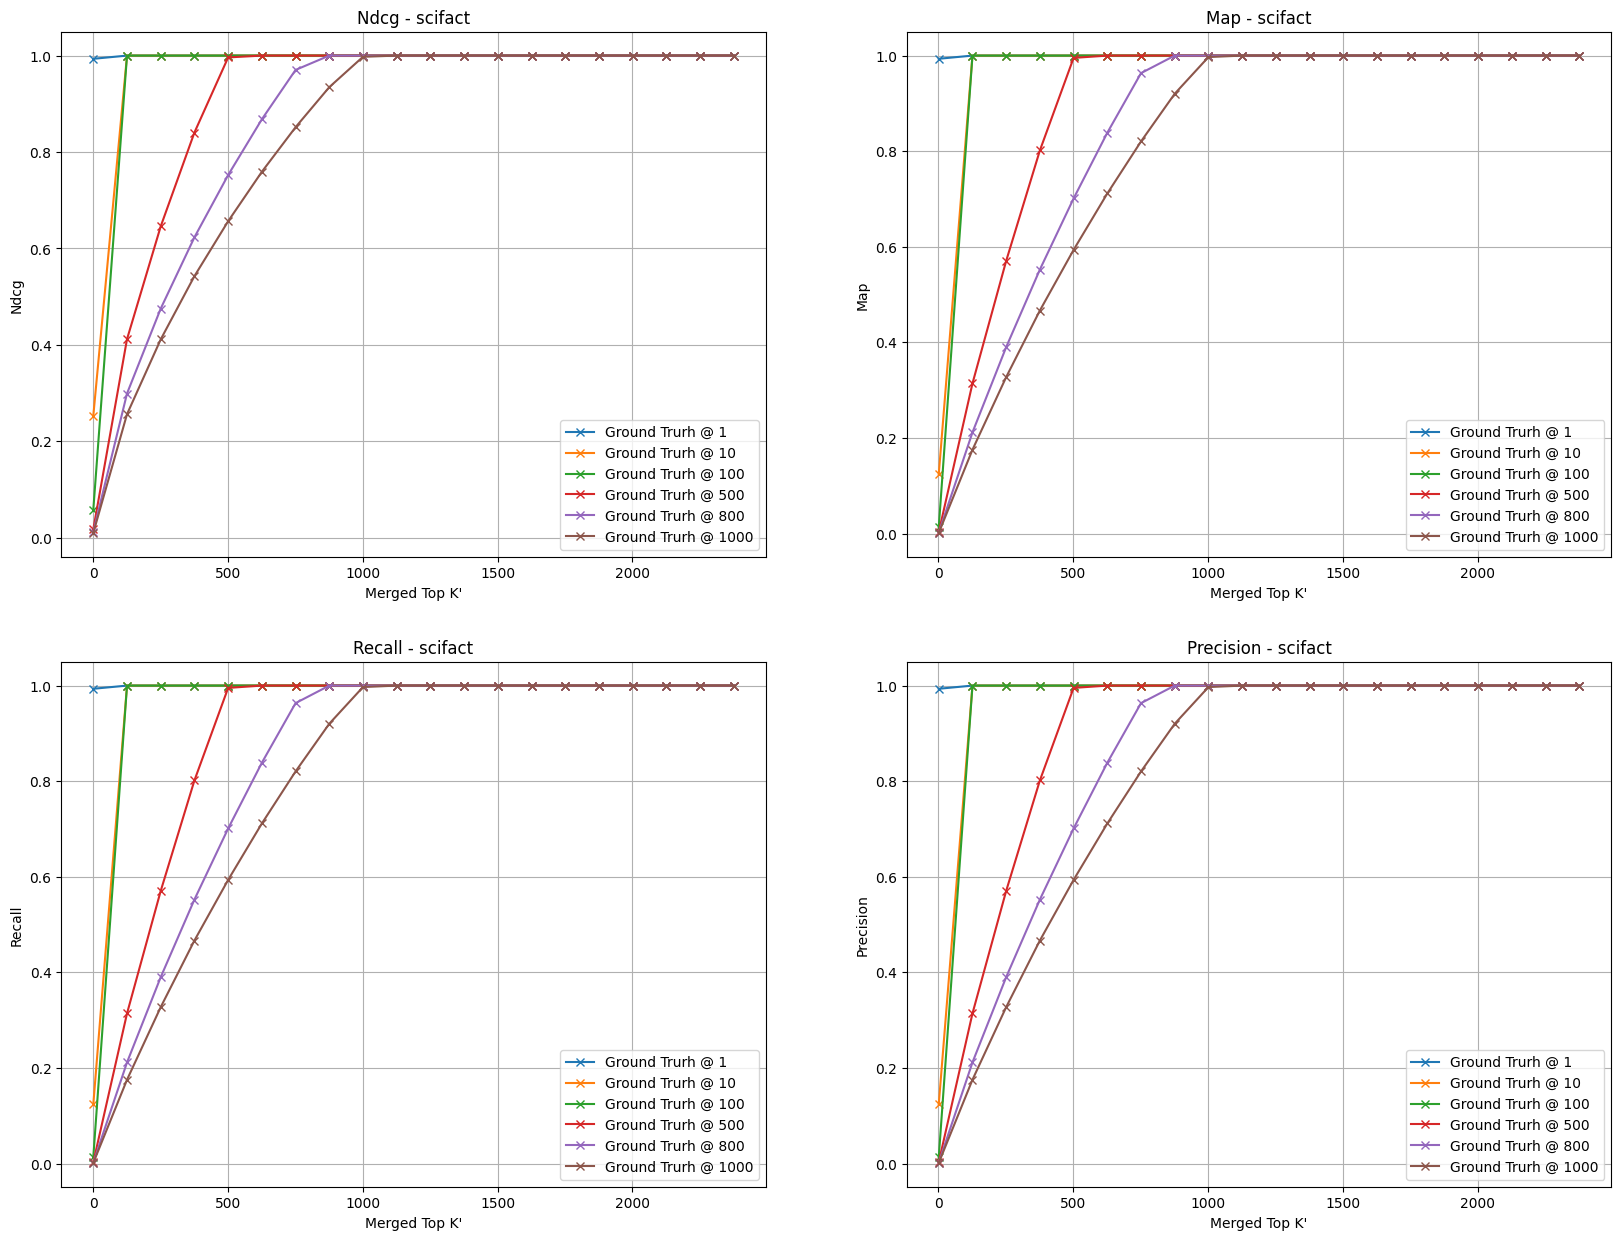

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

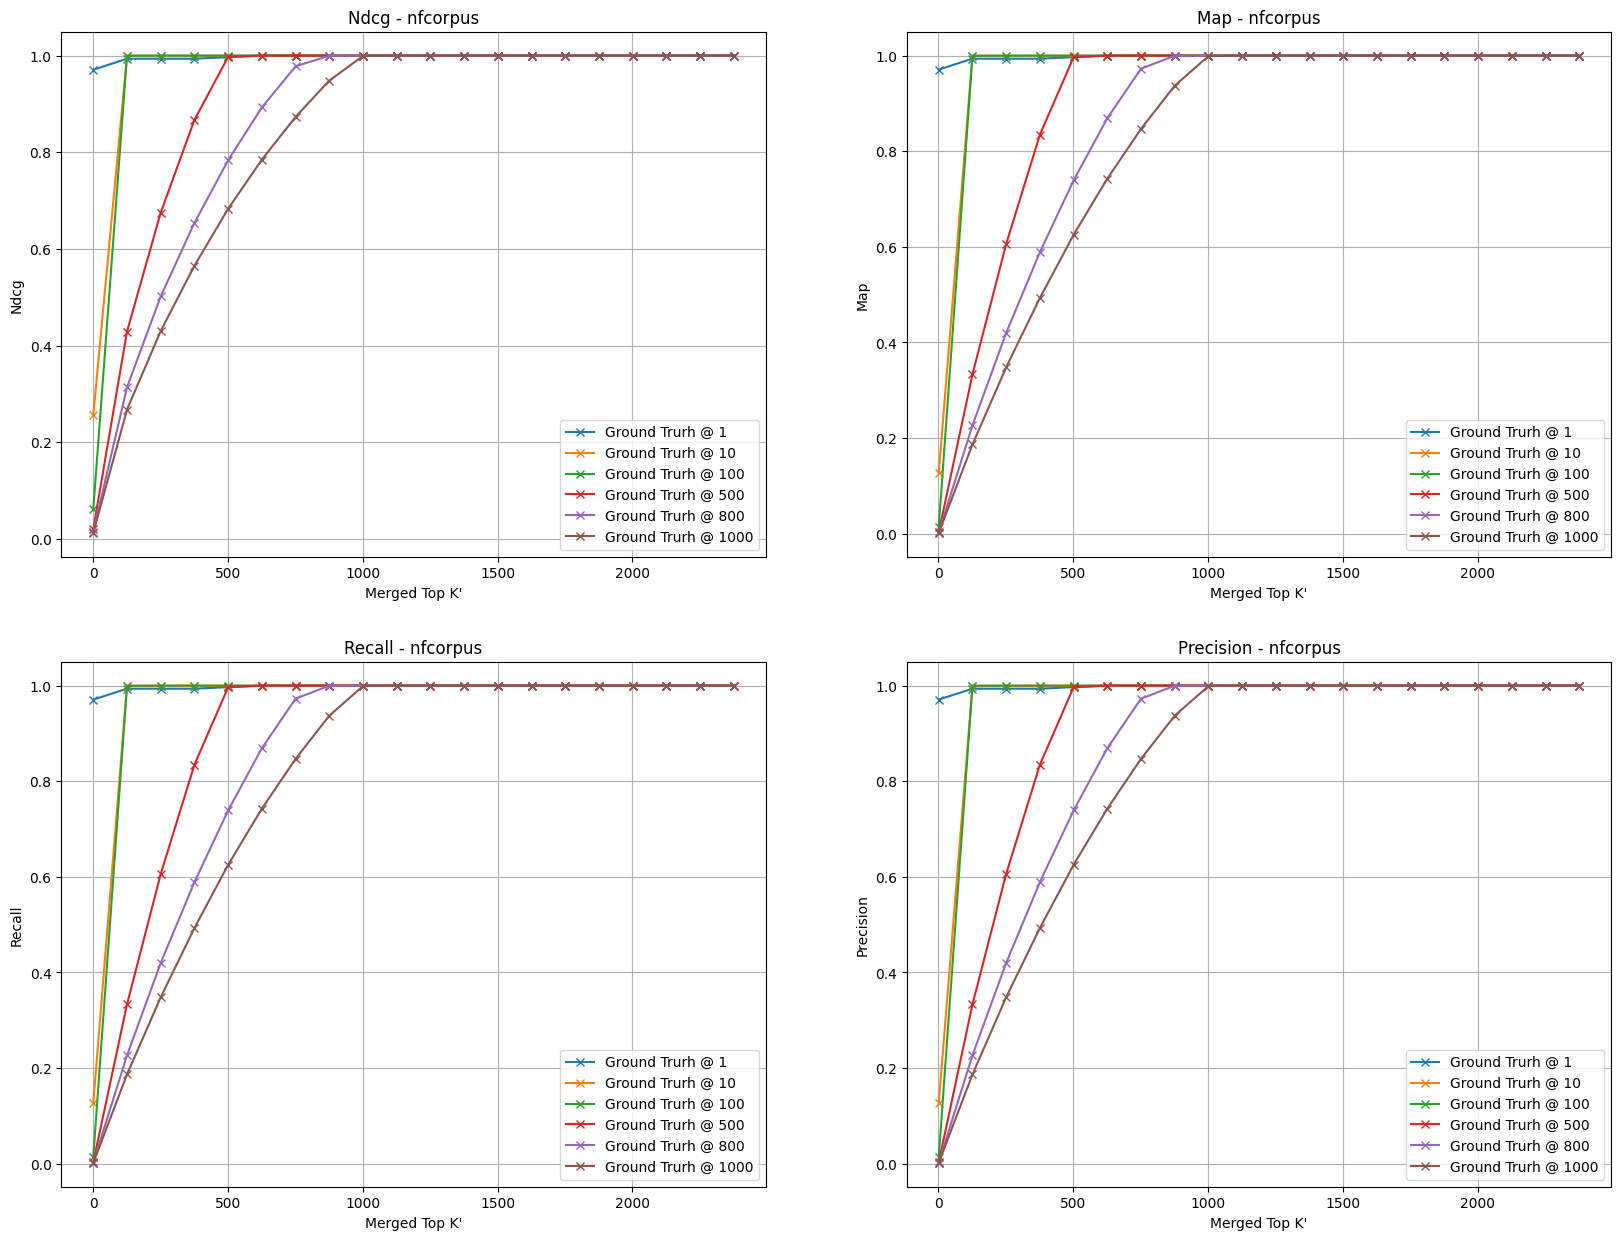

<IPython.core.display.Javascript object>

In [ ]:
print_graph_scores(datasets, res_evaluate_top_k_prime)